In [2]:
import random
import os
import urllib3
import pandas as pd
from pandas import Series
import geopandas as gpd
from geopy import distance
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import imageio
from matplotlib.lines import Line2D
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import patches
import math

COMMON_DIR = os.path.join(os.pardir, 'common')
sys.path.insert(1, COMMON_DIR)

import data_retreiver
import time_adjusted_price as money
print(dir(data_retreiver))
from datetime import date


['DATASETS', 'DATA_PATH', 'FAMILY_DATASETS', 'GEO_DATA', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'download_datasets', 'download_family_datasets', 'download_file', 'download_geo_data', 'gpd', 'load_csv_datasets', 'load_geo_datasets', 'os', 'pd', 'urllib3']


In [4]:
data_retreiver.download_family_datasets()
data_retreiver.download_geo_data()
print()

<AxesSubplot:>

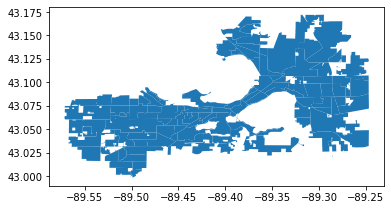

In [3]:
assessment_areas = data_retreiver.load_geo_datasets("single_family_areas_shapes")[0]
assessment_areas.plot()

In [4]:
(fam_core, existing_area_summaries) = data_retreiver.load_csv_datasets("single_family_core", "single_family_areas_info")
fam_sample = fam_core.sample(40000)
print(fam_core.columns)
fam_sample

Index(['XRefParcel', 'Address', 'PropertyClass', 'PropertyUse',
       'AssessmentArea', 'MoreThanOneBuild', 'HomeStyle', 'YearBuilt',
       'Bedrooms', 'FullBaths', 'HalfBaths', 'TotalLivingArea', 'FirstFloor',
       'SecondFloor', 'ThirdFloor', 'AboveThirdFloor', 'FinishedAttic',
       'Basement', 'FinishedBasement', 'ExteriorWall1', 'ExteriorWall2',
       'Fireplaces', 'CentralAir', 'LotSize', 'Zoning1', 'Zoning2', 'Zoning3',
       'Zoning4', 'FrontageStreet', 'WaterFrontage', 'TIFDistrict',
       'TaxSchoolDist', 'AttendanceSchool', 'ElementarySchool', 'MiddleSchool',
       'HighSchool', 'RefuseDistrict', 'AlderDistrict', 'ExemptionType',
       'FireDistrict', 'FloodPlain', 'FuelStorageProximity', 'HeatingDistrict',
       'LandfillProximity', 'Landmark', 'LandscapeBuffer',
       'LocalHistoricalDist', 'LotDepth', 'LotNumber', 'LotType1', 'LotType2',
       'LotWidth', 'NationalHistoricalDist', 'NoiseAirport', 'NoiseRailroad',
       'NoiseStreet', 'OwnerChangeDate', 'Owne

,XRefParcel,Address,PropertyClass,PropertyUse,AssessmentArea,MoreThanOneBuild,HomeStyle,YearBuilt,Bedrooms,FullBaths,...,Men,Women,Hispanic,White,Black,Native,Asian,IncomePerCap,Poverty,Recent_Sale_Year
Parcel,,,,,,,,,,,,,,,,,,,,,
70928305098,70928305098,3710 Odana Rd,Residential,Single family,17,NaN,Old Style,1939,3,1,...,1080.0,1569.0,3.10,91.70,1.80,0.00,1.50,42538.0,1.90,2004.0
71011405050,71011405050,1241 Alexandria Ln,Residential,Single family,96,NaN,Modern two story,2000,3,3,...,4398.5,4735.0,5.40,81.00,3.30,0.10,7.45,38087.0,4.10,2000.0
80925217162,80925217162,1310 Iowa Dr,Residential,Single family,48,NaN,Cape Cod,1963,4,1,...,1798.0,1976.0,7.65,66.50,11.15,0.20,10.00,26267.0,19.25,2010.0
60801113402,60801113402,5814 Idledale Cir,Residential,Single family,1,NaN,Ranch,1966,4,1,...,3672.0,3702.5,8.20,72.15,9.35,0.15,7.45,38027.0,6.45,2020.0
71006132080,71006132080,37 Farwell St,Residential,Single family,38,NaN,Old Style,1927,3,1,...,2472.0,3219.0,2.50,82.60,8.20,0.00,2.60,34981.0,9.50,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70928322133,70928322133,822 Oneida Pl,Residential,Single family,18,NaN,Tudor,1930,4,2,...,1349.0,1825.0,6.50,86.40,2.90,0.20,2.70,54055.0,3.40,2017.0
81028403062,81028403062,2013 Portage Rd,Residential,Single family,76,NaN,Ranch,1955,3,2,...,2827.5,2954.0,9.70,63.55,14.50,0.05,10.05,28357.0,9.80,2011.0
71005333051,71005333051,2705 Willard Ave,Residential,Single family,69,NaN,Bungalow,1924,2,1,...,2472.0,3219.0,2.50,82.60,8.20,0.00,2.60,34981.0,9.50,2013.0


In [6]:
#lat, lon
class Bounds:
    def __init__(self):
        pass

    def in_bounds(self, home):
        print("???")
        pass

    def filter_in_bounds(self, homes):
        return homes[homes.apply(lambda h: self.in_bounds(h), axis=1)]

    def generate_splits(self):
        pass

    def __repr__(self):
        return "Bounds()"

    def area(self):
        pass

    def patch(self):
        pass

class RectBounds(Bounds):
    def __init__(self, lon_low, lon_high, lat_low, lat_high):
        self.lon_low = lon_low
        self.lon_high = lon_high
        self.lat_low = lat_low
        self.lat_high = lat_high
        self.width = abs(lon_low - lon_high)
        self.height = abs(lat_low - lat_high)

    def in_bounds(self, home):
        h_lon = home["lon"]
        h_lat = home["lat"]

        in_lon_range = (self.lon_low <= h_lon and self.lon_high > h_lon)
        in_lat_range = (self.lat_low <= h_lat and self.lat_high > h_lat)
        result = (in_lon_range and in_lat_range)
        return result

    def split(self, on, at):
        if(on == "lat"):
            return (
                RectBounds(self.lon_low, self.lon_high, self.lat_low, at),
                RectBounds(self.lon_low, self.lon_high, at, self.lat_high)
            )
        else:
            return (
                RectBounds(self.lon_low, at, self.lat_low, self.lat_high),
                RectBounds(at, self.lon_high, self.lat_low, self.lat_high)
            )

    def generate_splits(self):
        result = [] # A list of tuples (Bound, Bound)

        num_partitions = 10
        delta_lon = abs(abs(self.lon_low) - abs(self.lon_high)) / num_partitions #TODO: replace this with width?
        lon_split_points = np.arange(self.lon_low, self.lon_high, delta_lon)[1:]

        delta_lat = abs(abs(self.lat_low) - abs(self.lat_high)) / num_partitions #TODO: replace this with width?
        lat_split_points = np.arange(self.lat_low, self.lat_high, delta_lat)[1:]

        for lon_split_point in lon_split_points:
            split1 = RectBounds(self.lon_low, lon_split_point, self.lat_low, self.lat_high)
            split2 = RectBounds(lon_split_point, self.lon_high, self.lat_low, self.lat_high)
            result.append((split1, split2))

        for lat_split_point in lat_split_points:
            split1 = RectBounds(self.lon_low, self.lon_high, self.lat_low, lat_split_point)
            split2 = RectBounds(self.lon_low, self.lon_high, lat_split_point, self.lat_high)
            result.append((split1, split2))

        return result

    def area(self):
        return self.width * self.height

    def patch(self, **kwargs):
        anchor = (self.lon_low, self.lat_low)
        return Rectangle(anchor, self.width, self.height, **kwargs)

    def __repr__(self):
        return f"RectBounds({self.lon_low}, {self.lon_high}, {self.lat_low}, {self.lat_high}, Area={self.area()*100})"

def stddev_time_adjusted_sales_prices_centered(data):
    target_mean = 300000
    sales_prices = data["Recent_Sales_Price_Inflated"].dropna().values
    sales_prices = np.array([p for p in sales_prices if p > 0])
    if(len(sales_prices) > 0):
        actual_mean = np.mean(sales_prices)
        factor_to_reach_target_mean = target_mean / actual_mean
        sales_prices_target_mean = sales_prices * factor_to_reach_target_mean
        return np.std(sales_prices_target_mean) 
    return np.std(sales_prices)

def stddev_growth_rate(data):
    growth_rates = data["Recent_Sales_Price_Growth"].dropna().values
    result = np.std(growth_rates) 
    return result

def sum_stddev_sales_prices(area1, area2):
    stddev_sales_prices1 = stddev_time_adjusted_sales_prices_centered(area1.homes)
    stddev_sales_prices2 = stddev_time_adjusted_sales_prices_centered(area2.homes)
    return stddev_sales_prices1 + stddev_sales_prices2

def diff_stddev_sales_prices(area1, area2):
    stddev_sales_prices1 = stddev_time_adjusted_sales_prices_centered(area1.homes)
    stddev_sales_prices2 = stddev_time_adjusted_sales_prices_centered(area2.homes)
    return abs(stddev_sales_prices1 - stddev_sales_prices2)

def diff_stddev_growth_rate(area1, area2):
    stddev_growth_1 = stddev_growth_rate(area1.homes)
    stddev_growth_2 = stddev_growth_rate(area2.homes)
    return abs(stddev_growth_1 - stddev_growth_2)

def sum_stddev_sales_prices_avg(area1, area2):
    stddev_sales_prices1 = stddev_time_adjusted_sales_prices_centered(area1.homes) / area1.num_homes
    stddev_sales_prices2 = stddev_time_adjusted_sales_prices_centered(area2.homes) / area2.num_homes
    return (stddev_sales_prices1 + stddev_sales_prices2)

def sum_stddev_sales_prices_avg2(area1, area2):
    stddev_sales_prices1 = stddev_time_adjusted_sales_prices_centered(area1.homes)
    stddev_sales_prices2 = stddev_time_adjusted_sales_prices_centered(area2.homes)
    return (stddev_sales_prices1 + stddev_sales_prices2) / (area1.num_homes + area2.num_homes)

def population_difference(area1, area2):
    return len(area1.homes) - len(area2.homes)
        
def are_partitions_large_enough(area1, area2):
    min_partition_area = (0.1/15) * (0.1/15)
    return (area1.area() > min_partition_area) and (area2.area() > min_partition_area)

def are_partitions_populous_enough(area1, area2):
    min_partition_homes = 20
    #print(area1.num_homes)
    return (area1.num_homes > min_partition_homes) and (area2.num_homes > min_partition_homes)

def are_proportions_comparable(n1, n2, comparison):
    n_low, n_high = sorted((n1, n2))
    proportion = n_low / n_high
    return proportion >= comparison

def are_dimmensions_reasonable(area1, area2, comparison):
    area1_reasonable = are_proportions_comparable(area1.bounds.width, area1.bounds.height, comparison)
    area2_reasonable = are_proportions_comparable(area2.bounds.width, area2.bounds.height, comparison)
    return area1_reasonable and area2_reasonable

def are_partition_populations_comparable(area1, area2, comparison):
    return are_proportions_comparable(len(area1.homes), len(area2.homes), comparison)

def partition_filter_v2(area1, area2):
    large_enough = are_partitions_large_enough(area1, area2)
    populous_enough = are_partitions_populous_enough(area1, area2)
    comparable_populations = are_partition_populations_comparable(area1, area2, 0.4)
    comparable_dimmentions = are_dimmensions_reasonable(area1, area2, 0.3)
    return large_enough and populous_enough and comparable_populations and comparable_dimmentions


class AssessmentArea:
    def __init__(self, all_homes, bounds, partition_filter_fn, partition_evaluation_fn, evaluation_fn_criteria = "MIN"):
        self.partition_filter_fn = partition_filter_fn # Takes in 2 AssessmentAreas -> returns true if they are to be considered.
        self.partition_evaluation_fn = partition_evaluation_fn # Takes in 2 AssessmentAreas -> 1 number
        self.evaluation_fn_criteria = evaluation_fn_criteria # "MIN" if we chould attempt to create splits that minimize the partition_evaluation_fn, or max otherwise.
        self.bounds = bounds
        self.homes = self.bounds.filter_in_bounds(all_homes)
        self.num_homes = len(self.homes)

    def area(self):
        return self.bounds.area()

    def partition(self):
        #print("begin Partition")
        bounds_splits = self.bounds.generate_splits()
        partitions = [] # list of tuples ((AssessmentArea, AssessmentArea), score)
        for (bounds1, bounds2) in bounds_splits:
            area1 = AssessmentArea(self.homes, bounds1, self.partition_filter_fn, self.partition_evaluation_fn, self.evaluation_fn_criteria)
            area2 = AssessmentArea(self.homes, bounds2, self.partition_filter_fn, self.partition_evaluation_fn, self.evaluation_fn_criteria)
            if(self.partition_filter_fn(area1, area2)):
                evaluation_score = self.partition_evaluation_fn(area1, area2)
                partitions.append(((area1, area2), evaluation_score))
        #print("Partitions Scored")
        best_areas = None
        best_score = None
        if(self.evaluation_fn_criteria == "MIN"):
            best_score = float("inf")
            for (partition, score) in partitions:
                if(score < best_score):
                    best_score = score
                    best_areas = partition
        else:
            best_score = float("-inf")
            for (partition, score) in partitions:
                if(score > best_score):
                    best_score = score
                    best_areas = partition
        if(best_areas is None):
            print(self, len(partitions))

        return (best_areas, best_score)

    def patch(self):
        patch = self.bounds.patch(edgecolor='r', alpha=0.5)
        patch.set_facecolor(None)
        return patch



    def __repr__(self):
        return f"AssessmentArea(Bounds: {self.bounds.__repr__()}, Homes: {self.num_homes})"

        

        



In [7]:
START_BOUNDS = RectBounds(-89.57, -89.245, 43.00, 43.17)
(south, north) = START_BOUNDS.split("lat", 43.09)
(lake, northeast) = north.split("lon", -89.4)

madison_south = AssessmentArea(fam_core, south, partition_filter_v2, diff_stddev_growth_rate)
madison_northeast= AssessmentArea(fam_core, northeast, partition_filter_v2, diff_stddev_growth_rate)


In [8]:
def partition_areas(starting_area):
    result = []
    partition_areas_recursive(starting_area, 7, result)
    return result

def partition_areas_recursive(area, fuse_remaining, accumulator):
    if(fuse_remaining == 0):
        accumulator.append(area)
    else:
        (partition, score) = area.partition()
        if(partition is not None):
            print(fuse_remaining, area.__repr__())
            partition_areas_recursive(partition[0], fuse_remaining-1, accumulator)
            partition_areas_recursive(partition[1], fuse_remaining-1, accumulator)
        else:
            accumulator.append(area)

In [9]:
northeast_portions = partition_areas(madison_northeast)
south_portions = partition_areas(madison_south)
all_portions = northeast_portions + south_portions
all_portions

7 AssessmentArea(Bounds: RectBounds(-89.4, -89.245, 43.09, 43.17, Area=1.2399999999999827), Homes: 13792)
6 AssessmentArea(Bounds: RectBounds(-89.4, -89.3535, 43.09, 43.17, Area=0.372000000000063), Homes: 4950)
5 AssessmentArea(Bounds: RectBounds(-89.4, -89.3535, 43.09, 43.13000000000002, Area=0.1860000000000976), Homes: 1947)
AssessmentArea(Bounds: RectBounds(-89.4, -89.3535, 43.09, 43.11400000000003, Area=0.11160000000015767), Homes: 718) 0
4 AssessmentArea(Bounds: RectBounds(-89.4, -89.3535, 43.11400000000003, 43.13000000000002, Area=0.07439999999993992), Homes: 1229)
AssessmentArea(Bounds: RectBounds(-89.4, -89.36280000000002, 43.11400000000003, 43.13000000000002, Area=0.05951999999991556), Homes: 489) 0
3 AssessmentArea(Bounds: RectBounds(-89.36280000000002, -89.3535, 43.11400000000003, 43.13000000000002, Area=0.014880000000024363), Homes: 740)
AssessmentArea(Bounds: RectBounds(-89.36280000000002, -89.3535, 43.11400000000003, 43.122000000000014, Area=0.0074400000000022695), Homes:

[AssessmentArea(Bounds: RectBounds(-89.4, -89.3535, 43.09, 43.11400000000003, Area=0.11160000000015767), Homes: 718),
 AssessmentArea(Bounds: RectBounds(-89.4, -89.36280000000002, 43.11400000000003, 43.13000000000002, Area=0.05951999999991556), Homes: 489),
 AssessmentArea(Bounds: RectBounds(-89.36280000000002, -89.3535, 43.11400000000003, 43.122000000000014, Area=0.0074400000000022695), Homes: 477),
 AssessmentArea(Bounds: RectBounds(-89.36280000000002, -89.3535, 43.122000000000014, 43.13000000000002, Area=0.007440000000022094), Homes: 263),
 AssessmentArea(Bounds: RectBounds(-89.4, -89.38325999999998, 43.13000000000002, 43.136, Area=0.010043999999992831), Homes: 208),
 AssessmentArea(Bounds: RectBounds(-89.4, -89.39162999999996, 43.136, 43.14200000000001, Area=0.0050220000000313104), Homes: 86),
 AssessmentArea(Bounds: RectBounds(-89.39162999999996, -89.38325999999998, 43.136, 43.14200000000001, Area=0.005021999999997204), Homes: 118),
 AssessmentArea(Bounds: RectBounds(-89.383259999

In [10]:
portion_homes_file_contents = ""
for portion in all_portions:
    portion_homes = list(portion.homes.index.values)
    line_content = ",".join(portion_homes) + "\n"
    portion_homes_file_contents += line_content

with open("areas_sales_price_growths.txt", "w") as f:
    f.write(portion_homes_file_contents)
    

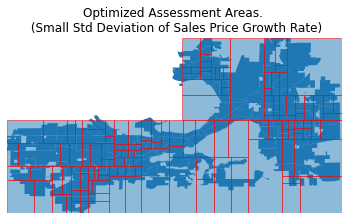

In [10]:
def setup_map_axes():
    fig1, ax1 = plt.subplots()
    ax1.set_axis_off()
    ax1.set_xlim(-89.57, -89.245)
    ax1.set_ylim(43.00, 43.17)
    ax1.margins(0.0)
    #fig1.tight_layout()
    return (fig1, ax1)

def plot_area_boundries(ax, assessment_areas):
    patches = []
    for area in assessment_areas:
        ax.add_patch(area.patch())
    return ax

fig, axa = setup_map_axes()
axa.set_title("Optimized Assessment Areas. \n (Small Std Deviation of Sales Price Growth Rate)")
start = assessment_areas.plot(ax=axa)
plot_area_boundries(start, all_portions)
fig.savefig("assmt_area_growth_opt.svg")

<AxesSubplot:title={'center':'Distribution of Std. Deviations of Sales Price Growth Rate \n between new and old assessment areas.'}, ylabel='Density'>

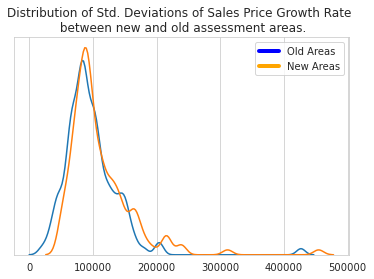

In [15]:
std_devs_new = []
for area in all_portions:
    std_devs_new.append(stddev_time_adjusted_sales_prices_centered(area.homes))

std_devs_old = existing_area_summaries["Sales_Price_Std"].values

#fig, ax = plt.subplots()
#ax.get_yaxis().set_visible(False)
#ax.hist(std_devs_old, bins=30, alpha=0.5)
#ax.hist(std_devs_new, bins=30, alpha=0.5)

sns.set_style('whitegrid')
p = sns.kdeplot(np.array(std_devs_old), bw=0.15)
p = sns.kdeplot(np.array(std_devs_new), bw=0.15)
p.set_title("Distribution of Std. Deviations of Sales Price Growth Rate \n between new and old assessment areas.")
p.get_yaxis().set_visible(False)
legend_elements = [Line2D([0], [0], color='blue', lw=4, label='Old Areas'), Line2D([0], [0], color='orange', lw=4, label='New Areas')]

p.legend(handles=legend_elements)
p.figure.savefig("new_area_price_hist.svg")
p

In [171]:
p.cla()